In [43]:
import numpy as np
from numpy.polynomial import Polynomial, Laguerre
import scipy.stats as stats
from scipy.interpolate import CubicSpline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
import QuantLib as ql
from multiprocess import Pool
from tqdm import tqdm
import matplotlib.pyplot as plt

# Calibration for Yield Curve

We got Instanteneous Forward Rates for AAA rated bonds from ECB:
https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html

And we get the initial Interest Rate from here:
https://www.ecb.europa.eu/stats/policy_and_exchange_rates/key_ecb_interest_rates/html/index.en.html

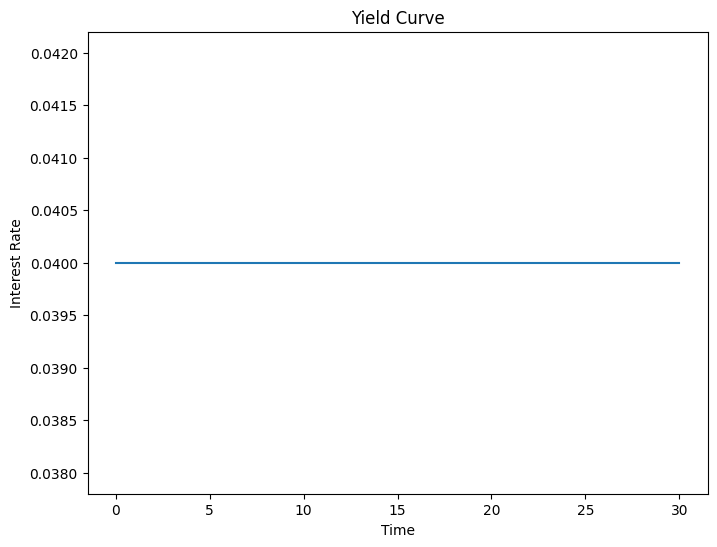

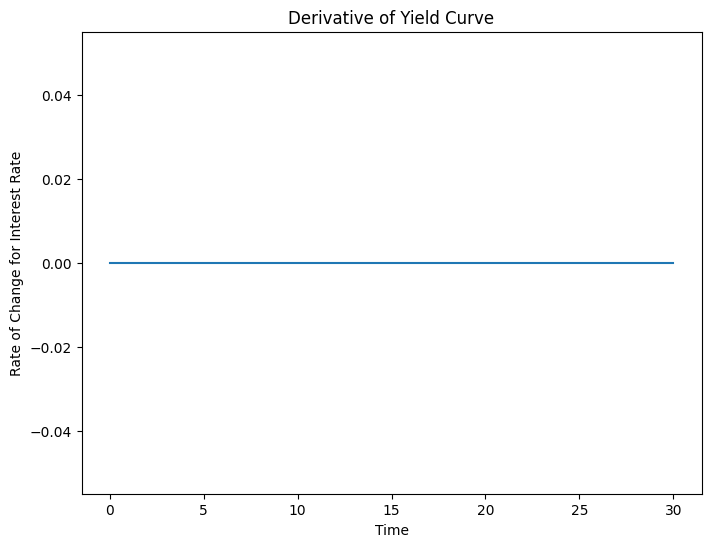

In [44]:
# Interest Rates
r0 = 0.04
# ECB Market Yield Curve on 7th November 2023 (Humped)
market_yields = [
    (0.25, .03708004),
    (0.50, .03480834),
    (0.75, .03205257),
    (1.0, .02944257),
    (2.0, .02342641),
    (3.0, .02264375),
    (4.0, .02372672),
    (5.0, .02519909),
    (6.0, .02661483),
    (7.0, .02786643),
    (8.0, .02894020),
    (9.0, .02984566),
    (10.0, .03059704),
    (11.0, .03120873),
    (12.0, .03169425),
    (13.0, .03206610),
    (14.0, .03233577),
    (15.0, .03251381),
    (16.0, .03260989),
    (17.0, .03263287),
    (18.0, .03259087),
    (19.0, .03249129),
    (20.0, .03234093),
    (21.0, .03214597),
    (22.0, .03191205),
    (23.0, .03164432),
    (24.0, .03134746),
    (25.0, .03102571),
    (26.0, .03068293),
    (27.0, .03032262),
    (28.0, .02994794),
    (29.0, .02956175),
    (30.0, .02916661),
]
# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
# Normal(Upward) Yield Curve
upward_yields = [
    (0.25, .041),
    (1.0, .042),
    (2.0, .043),
    (4.0, .044),
    (8.0, .0452),
    (12.0, .046),
    (24.0, .047),
    (30.0, .0471),
]
# Inverted Yield Curve
downward_yields = [
    (0.25, .039),
    (1.0, .038),
    (2.0, .037),
    (4.0, .036),
    (8.0, .0348),
    (12.0, .034),
    (24.0, .033),
    (30.0, .0329),
]

# Extract durations and yields
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]

# Fit cubic spline
yield_curve = CubicSpline(durations, yields)

# Visualize the Fitted Curve
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields = yield_curve(maturities)   # Get the corresponding yields to maturity
plt.figure(1, figsize=(8,6))
plt.title("Yield Curve")
plt.xlabel("Time")
plt.ylabel("Interest Rate")
plt.plot(maturities, fitted_yields)

# Visualize the Fitted Curve dt
maturities = np.linspace(0.0, 30, 100)    # Generate 100 points (maturity time points) between 0.0 and 30.0
fitted_yields_dt = yield_curve.derivative(nu=1)(maturities)   # Get the corresponding yields to maturity
plt.figure(2, figsize=(8,6))
plt.title("Derivative of Yield Curve")
plt.xlabel("Time")
plt.ylabel("Rate of Change for Interest Rate")
plt.plot(maturities, fitted_yields_dt)

# Hull-White (One Factor Model)

Assumptions:
1. Speed of reversion is constant $\alpha$, to be obtained from current market structure
2. Volatility is constant $\sigma$, to be obtained from current market structure
3. Reversion level is time dependent, $\theta(t)$ is chosen to make the model consistent with the initial term structure, which we get from ECB yield curve.


$$
dr(t) = \alpha[\frac{\theta(t)}{\alpha}-r(t)]dt + \sigma dW(t)
$$

$$
\theta(t)=F_t(0, t)+a F(0, t)+\frac{\sigma^2}{2 a}\left(1-e^{-2 a t}\right)
$$
Where $F$ is market's instanteneous forward rate and $F_t$ is its derivative.


In [45]:
# Simulation's Parameters
T = 12                      # Years of Simulation
months_per_year = 12         # Days in the Year
steps = int(T*months_per_year)    # Number of steps
dt = 1.0 * T / steps            # Time step size
simulations = 10_000         # Amount of Monte Carlo runs

# Parameters for the Hull-White model
# a: How fast is convergence to the original Yield Structure. Typical Range: [0.01, 0.1], our range: [0.01, 0.1]
# sigma: Variance of rates. Typical range: [0.001, 0.02], our range: [0.002, 0.01]
#a = 0.01
#sigma = 0.002
a = 0.01
sigma = 0.01
#a = 0.1
#sigma = 0.002
#a = 0.1
#sigma = 0.01
theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))

In [46]:
# I decided not to implement vectorized explicit formula (integrals still need for loop), so I parallelyzed drift generator
# Define the function that simulates a single path
def get_short_rates(simulations, steps, dt, r0, a, sigma, theta, yield_curve):
    def simulate_path(params):

        _, Z, steps, dt, r0, a, sigma, theta, yield_curve = params

        import numpy as np

        theta = lambda t: yield_curve.derivative(nu=1)(t) + (a*yield_curve(t)) + ((sigma**2)/(2*a))*(1-np.exp(-2*a*t))
        dr = np.zeros(steps)
        r = np.zeros(steps)
        r[0] = r0  # Initialize with the initial rate from the market
        for t in range(1, steps):
            dr[t] = (theta(t * dt) - a * r[t-1]) * dt + sigma * np.sqrt(dt) * Z[t]
            r[t] = r[t-1] + dr[t]
        return r

    # Use multiprocess to run simulations in parallel
    # Generating all the random numbers at the same moment to reduce variance + Using Antitheti Variables
    random_part_1 = np.random.normal(0, 1, size=(int(simulations/2), steps))    
    random_part_2 = -random_part_1
    random_z = np.vstack((random_part_1, random_part_2))
    simulation_params = [(i, random_z[i,:], steps, dt, r0, a, sigma, theta, yield_curve) for i in range(simulations)]

    # Run in Parallel
    with Pool() as pool:
        short_rate_paths = pool.map(simulate_path, simulation_params)

    return np.array(short_rate_paths)

# Convert list of arrays to a 2D NumPy array
short_rate_paths = get_short_rates(simulations, steps, dt, r0, a, sigma, theta, yield_curve)

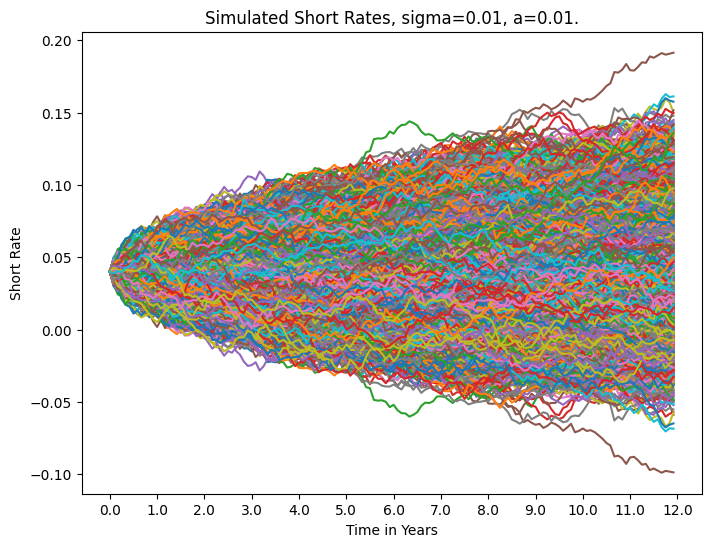

In [47]:
plt.figure(figsize=(8,6))
plt.plot(short_rate_paths.T)
plt.title("Simulated Short Rates, sigma=" + str(sigma) + ", a=" + str(a) + ".")
locs = [x for x in np.linspace(0, T*months_per_year, int(T+1), dtype=int)]
labels = ["%.1f" %x for x in np.linspace(0, T, int(T+1))]
plt.xticks(locs, labels)
plt.xlabel("Time in Years")
plt.ylabel("Short Rate")
plt.show()

## Analytical Verification (Is done in another file)

For Hull-White model we have an analytical solution for both mean and variance of short-rates at any $t$ as observed from $t=0$. These are: 
$$
\begin{aligned}
\mathbb{E}^Q\left(r(t) \mid \mathcal{F}_0\right) & =r(0) e^{a(0-t)}+\int_0^t e^{a(u-t)} \theta(u) d u \\
\operatorname{Var}\left(r(t) \mid \mathcal{F}_0\right) &=\frac{\sigma^2}{2 a}\left(1-e^{2 a(0-t)}\right)
\end{aligned}
$$

In [48]:
# analytical_short_rates = []
# for t in np.linspace(0, T, steps):
#     integral = 0
#     for u in np.linspace(0, t, int(t*months_per_year)):
#         integral += np.exp(a*(u-t))*theta(u)*dt         # du=dt as we keep discretization step size same
#     rate_t = r0*np.exp(a*(0-t)) + integral
#     analytical_short_rates.append(rate_t)
# mean_sol = np.mean(analytical_short_rates)              # Should we add confidence interval?

# analytical_variance_rates = []
# for t in np.linspace(0, T, steps):
#     var_t = ((np.square(sigma))/(2*a)) * (1 - np.exp(2 * a * (0-t)))
#     analytical_variance_rates.append(var_t)
# variance_sol = np.mean(analytical_variance_rates)       # Should we add confidence interval?

# print("Analytical Solution for the Mean: ", mean_sol)
# print("Analytical Solution for the Variance: ", variance_sol)

In [49]:
# # Some variables necessary for statistical tests
# confidence_level = 0.95
# d_f = simulations - 1
# # T-test for the Mean
# t_critical = stats.t.ppf((1 + confidence_level) / 2, d_f)
# # Chi-squared test for the Variance
# chi2_lower = stats.chi2.ppf((1 - confidence_level) / 2, d_f)
# chi2_upper = stats.chi2.ppf((1 + confidence_level) / 2, d_f)

# # Mean
# sim_means = [np.mean(short_rates) for short_rates in short_rate_paths.T]    # We have to transpose, because analytical value is obtained per each time point, not per path
# overall_sim_mean = np.mean(sim_means)
# # Confidence Interval for the mean
# mean_err = stats.sem(sim_means)  # Standard Error Mean
# ci_mean = t_critical * mean_err
# print("Simulation's Short Rate Mean: ", overall_sim_mean, ", with a ci: [", overall_sim_mean-ci_mean, ", ", overall_sim_mean+ci_mean, "]")

# # Variance
# sim_vars = [np.var(short_rates, ddof=1) for short_rates in short_rate_paths.T]    # degree_of_freedom = n-1, because it is variance
# overall_sim_var = np.mean(sim_vars) + np.var(sim_vars, ddof=1)  # Variance within and between
# # Confidence Interval for the variance
# ci_variance_lower = (d_f * overall_sim_var) / chi2_upper
# ci_variance_upper = (d_f * overall_sim_var) / chi2_lower
# print("Simulation's Short Rate Variance is: ", overall_sim_var, ", with a ci: [", ci_variance_lower, ", ", ci_variance_upper, "]")

# Pricing Swaption

First, we must price in simpler instruments.

## Evaluating Bond

In [50]:
# Example:
s = 0.0    # For which point in time we want to find value of coupon bond (We are interested in today)
t = 10.0   # What is the maturity of coupon bond (final time)
r = 0.04   # We need to access correct short rate at time s (We assume flat curve for now)
yield_curve_examples = CubicSpline(np.arange(int((t+1)*months_per_year)), np.ones(int((t+1)*months_per_year))*r)

In [51]:
def P(s, t, r_s, a, sigma, yield_curve):

    def A(s, t, a, sigma, yield_curve):   
        P_0_t = np.exp(-yield_curve(t)*t)     # Value of Zero Coupon Bond (0,t)
        P_0_s = np.exp(-yield_curve(s)*s)     # Value of Zero Coupon Bond (0,s)
        term1 = P_0_t/P_0_s                 
        term2 = B(s, t, a) * yield_curve(s) # B * Instantenious Forward Rate
        term3 = (sigma**2/(4*a)) * B(s,t,a)**2 * (1-np.exp(-2*a*s))
        return term1*np.exp(term2-term3)

    def B(s, t, a):
        return 1/a * (1 - np.exp(a * (s - t)))
        
    return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r_s)     # Short rate and initial rate are the same here

bond_price = P(s, t, r, a, sigma, yield_curve_examples)    # Where s is evaluating point in time, t is maturity point in time,
print("Bond's price for given parameters is: ", bond_price)

Bond's price for given parameters is:  0.6703200460356393


In [52]:
def bond_price_ql(s, t, r):
    # Verifying found Price
    todays_date = ql.Date(1, 1, 2023)
    ql.Settings.instance().evaluationDate = todays_date + ql.Period(int(s*12), ql.Months)

    # Create a bond object
    issue_date = todays_date + ql.Period(int(s*12), ql.Months)
    maturity_date = todays_date + ql.Period(int(t*12), ql.Months)
    bond = ql.ZeroCouponBond(0, ql.NullCalendar(), 1.0, maturity_date)

    # Set up the bond engine
    spot_curve_handle = ql.YieldTermStructureHandle(ql.FlatForward(issue_date, r, ql.Actual365Fixed()))
    bond_engine = ql.DiscountingBondEngine(spot_curve_handle)

    # Calculate the bond price
    bond.setPricingEngine(bond_engine)
    bond_NPV = bond.NPV()

    return bond_NPV

print("QuantLib Bond price is: ", bond_price_ql(s, t, r))

QuantLib Bond price is:  0.6700997030651691


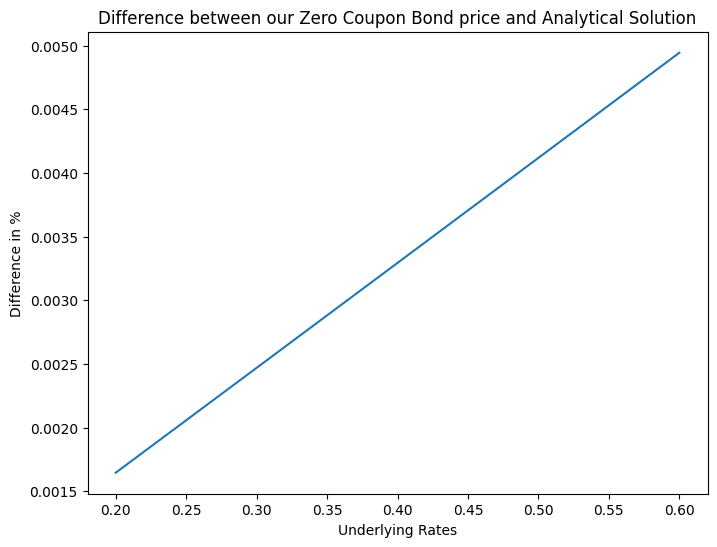

In [53]:
# Example:
s = 0.0    # For which point in time we want to find value of coupon bond (We are interested in today)
t = 10.0   # What is the maturity of coupon bond, let's say 10 years. It is a long enough period to see how stochasticity influences

r_range = np.linspace(0.2, 0.6)
difference = []
for r in r_range:
    # Creating flat yield curve structure for experiment
    yield_curve_examples = CubicSpline(np.arange(int(20.0*months_per_year)), np.ones(int(20.0*months_per_year))*r)
    bond_price_HW = P(s, t, r, a, sigma, yield_curve_examples)
    bond_price_QL = bond_price_ql(s, t, r)
    difference.append(np.abs(bond_price_HW - bond_price_QL)/bond_price_QL)

plt.figure(figsize=(8,6))
plt.plot(r_range, difference)
plt.title("Difference between our Zero Coupon Bond price and Analytical Solution")
plt.xlabel("Underlying Rates")
plt.ylabel("Difference in %")
plt.show()

## Pricing Swap

In [54]:
t = 0.0                 # Point in time when we are looking for contract
tenor = 0.5             # Semi-Annual settlement possibility, delta t_i
T_m = 5.0               # Point in time when contract ends (Maturity)
fixed_rate = 0.04       # Same as Strike Rate in simple options
N = 1                   # Notional Amount
r = 0.04                # Initial Forward Interest Rate
rates_example = np.ones(int((t+1)*months_per_year))*r                                     # Assume flat rates
yield_curve_examples = CubicSpline(np.arange(int((t+1)*months_per_year)), rates_example)

In [55]:
def V(months_per_year, t, T_0, T_m, N, fixed_rate, tenor, rates, a, sigma, yield_curve):
    term1 = P(t, T_0, rates[int(months_per_year*t)], a, sigma, yield_curve)
    term2 = P(t, T_m, rates[int(months_per_year*t)], a, sigma, yield_curve)
    term3 = 0
    for T_i in np.arange(T_0+tenor, T_m+tenor, tenor):       # For all intermediate and last one payout dates (np.arange does not include m)
        term3 += P(t, T_i, rates[int(months_per_year*t)],  a, sigma, yield_curve) * tenor
    return -N*(term1 - term2 - fixed_rate*term3)

# Example
swap_price = V(months_per_year, t, t, T_m, N, fixed_rate, tenor, rates_example, a, sigma, yield_curve_examples)
print("Swap's price for given parameters is: ", swap_price)

Swap's price for given parameters is:  -0.0018066502012711594


In [56]:
# Verifying values by running a simulation with the QuantLib (only works with flat curve)
def swap_value_ql(t, T_0, T_m, fixed_rate, tenor, r0):

    # Setup the market and yield term structure
    calendar = ql.TARGET()
    day_count = ql.Actual365Fixed()
    todays_date = ql.Date(1, 1, 2023)
    # Update the evaluation date
    evaluation_date = todays_date + ql.Period(int(t*12), ql.Months)
    ql.Settings.instance().evaluationDate = evaluation_date
    flat_forward = ql.FlatForward(evaluation_date, r0, day_count)     # Flat rate curve
    yield_curve_handle = ql.YieldTermStructureHandle(flat_forward)

    # Swaption characteristics
    # Define the fixed-rate leg
    maturity_date = todays_date + ql.Period(int(T_m*12), ql.Months)
    fixed_leg_tenor = ql.Period(int(tenor*12), ql.Months)
    fixed_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, fixed_leg_tenor, calendar,
                                    ql.ModifiedFollowing, ql.ModifiedFollowing,
                                    ql.DateGeneration.Forward, False)

    # Define the floating-rate leg
    index = ql.IborIndex("CustomEuriborM", ql.Period(int(tenor*12), ql.Months), 0, ql.EURCurrency(), calendar, ql.ModifiedFollowing, False, day_count, yield_curve_handle)
    floating_leg_schedule = ql.Schedule(todays_date+ql.Period(int(T_0*12), ql.Months), maturity_date, index.tenor(), calendar,
                                        ql.ModifiedFollowing, ql.ModifiedFollowing,
                                        ql.DateGeneration.Forward, False)

    # Create the swap
    vanilla_swap = ql.VanillaSwap(ql.VanillaSwap.Receiver, 1.0, fixed_leg_schedule,
                                fixed_rate, day_count, floating_leg_schedule,
                                index, 0.0, index.dayCounter())
    vanilla_swap.setPricingEngine(ql.DiscountingSwapEngine(yield_curve_handle))

    # Calculate the NPV
    swap_NPV = vanilla_swap.NPV()
    return swap_NPV

print("QuantLib Swap price is: ", swap_value_ql(t, t, T_m, fixed_rate, tenor, r))

QuantLib Swap price is:  -0.001810424301411262


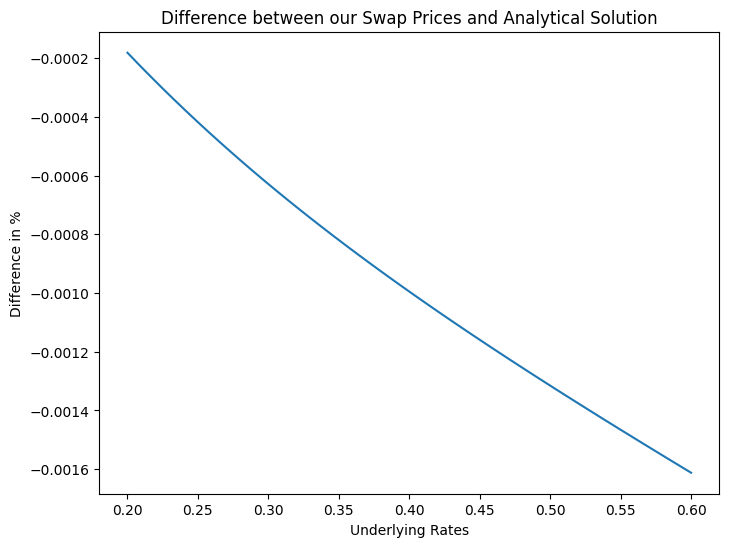

In [57]:
t = 0.0                 # Point in time when we are looking for contract
tenor = 1.0             # Semi-Annual settlement possibility, delta t_i
#T_0 = t + tenor         # Point in time when contract starts, in our case only structure where first payment is possible after a tenor is supported. (no custom no-call periods)
T_m = 10.0              # Point in time when contract ends (Maturity)
fixed_rate = 0.04       # Same as Strike Rate in simple options
N = 1                   # Notional Amount

r_range = np.linspace(0.2, 0.6)
difference = []
for r in r_range:
    # Creating flat yield curve structure for experiment
    rates_example = np.ones(int((T_m+1)*months_per_year))*r
    yield_curve_examples = CubicSpline(np.arange(int((T_m+1)*months_per_year)), np.ones(int((T_m+1)*months_per_year))*r)
    swap_price_HW = V(months_per_year, t, t, T_m, N, fixed_rate, tenor, rates_example, a, sigma, yield_curve_examples)
    swap_price_QL = swap_value_ql(t, t, T_m, fixed_rate, tenor, r)
    difference.append(np.abs(swap_price_HW - swap_price_QL)/swap_price_QL)

plt.figure(figsize=(8,6))
plt.plot(r_range, difference)
plt.title("Difference between our Swap Prices and Analytical Solution")
plt.xlabel("Underlying Rates")
plt.ylabel("Difference in %")
plt.show()

## Pricing Bermudan Swaption with LSM

1. For each simulation path we need to find possible value of swap on each time period of interest.
2. Regress with LSM to find the optimal point to enter a swap.
3. Discount through time each path.
4. Find average.

### Swap value at each point of time of interest

In [58]:
# Swaption parameters
T_m = 5.0               # Maximum duration of swaption (Maturity)
tenor = 1.0            # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
fixed_rate = 0.04      # Strike rate
N = 1                   # Notional Amount
short_rate_paths        # Already simulated paths for short rates
rates = np.ones(int((T_m+1)*months_per_year))*r0                 # Assume flat rates

In [59]:
# Convert list of arrays to a 2D NumPy array
def get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma):
    # Swap Values calculator
    def sim_swap_eval(params):
        _, months_per_year, T_m, tenor, N, fixed_rate, short_rate_path, yield_curve, a, sigma = params

        import numpy as np

        # Bond Evaluation
        def P(s, t, r_s, a, sigma, yield_curve):

            def A(s, t, a, sigma, yield_curve):   
                P_0_t = np.exp(-yield_curve(t)*t)     # Value of Zero Coupon Bond (0,t)
                P_0_s = np.exp(-yield_curve(s)*s)     # Value of Zero Coupon Bond (0,s)
                term1 = P_0_t/P_0_s                 
                term2 = B(s, t, a) * yield_curve(s) # B * Instantenious Forward Rate
                term3 = (sigma**2/(4*a)) * B(s,t,a)**2 * (1-np.exp(-2*a*s))
                return term1*np.exp(term2-term3)

            def B(s, t, a):
                return 1/a * (1 - np.exp(a * (s - t)))
                
            return A(s, t, a, sigma, yield_curve) * np.exp(-B(s, t, a) * r_s)     # Short rate and initial rate are the same here
        # Swap Evaluation
        def V(months_per_year, t, T_0, T_m, N, fixed_rate, tenor, rates, a, sigma, yield_curve):
            term1 = P(t, T_0, rates[int(months_per_year*t)], a, sigma, yield_curve)
            term2 = P(t, T_m, rates[int(months_per_year*t)], a, sigma, yield_curve)
            term3 = 0
            for T_i in np.arange(T_0+tenor, T_m+tenor, tenor):       # For all intermediate and last one payout dates (np.arange does not include m)
                term3 += P(t, T_i, rates[int(months_per_year*t)],  a, sigma, yield_curve) * tenor
            return -N*(term1 - term2 - fixed_rate*term3)     # (we are buying swaption) Only put makes sense, otherwise pointless to exercise early

        # Finding Swap Value for each possible exercise point
        swap_values = []
        for t in np.arange(tenor, T_m, tenor):     # Because of delay on starting of payments, we have less entries (Last one must be a tenor before Maturity)
            swap_values.append(V(months_per_year, t, t, T_m, N, fixed_rate, tenor, short_rate_path, a, sigma, yield_curve))
        return (swap_values)

    # Use multiprocess to run simulations in parallel
    simulation_params = [(i, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths[i], yield_curve, a, sigma) for i in range(simulations)]
    # Run in Parallel
    with Pool() as pool:
        simulations_swap_values = pool.map(sim_swap_eval, simulation_params)

    return np.array(simulations_swap_values)

simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
print(simulations_swap_values)

[[ 9.72056151e-03 -2.49808450e-03  1.15699915e-02 -1.86757806e-03]
 [ 1.66466516e-02  3.23658214e-02  3.01186857e-02  1.22994679e-02]
 [-1.14475646e-02 -4.75256614e-03 -7.47446711e-03  4.40142371e-03]
 [-2.51320668e-02 -3.23263143e-02 -1.75297717e-02 -1.66346657e-03]
 [-3.91759445e-02 -6.91326725e-03  1.76144144e-02  6.70286021e-03]
 [ 1.18375508e-02  3.93617193e-02 -5.13708411e-03  2.09924488e-03]
 [ 2.00691195e-02  3.85605459e-02  1.88347944e-02  2.14063006e-02]
 [-1.65718151e-02 -2.39996201e-02 -3.64409592e-03 -5.95031663e-03]
 [ 6.96519588e-02  1.00629978e-01  5.96693063e-02  3.87765479e-02]
 [-1.53842385e-03 -5.42263454e-03  1.18769634e-02  5.87015160e-03]
 [-2.21360650e-02  1.48048911e-03 -1.10699495e-03  7.60339154e-03]
 [-2.63043467e-02  4.10712865e-03  5.73136585e-03 -3.14678119e-03]
 [-4.95444303e-02 -7.27664280e-02 -1.25207280e-02 -1.04113036e-02]
 [-2.48307890e-02 -1.02543336e-01 -7.02949265e-02 -3.44408320e-02]
 [-1.67263341e-02  2.13618764e-02 -2.19155157e-03  1.16499330e

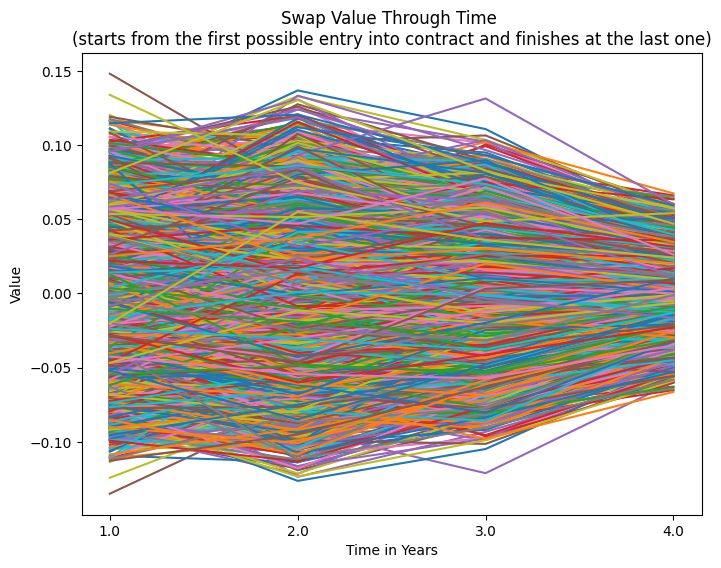

In [60]:
# Plotting paths that have meaning
plt.figure(figsize=(8,6))
plt.plot(simulations_swap_values.T)
plt.title("Swap Value Through Time \n(starts from the first possible entry into contract and finishes at the last one)")
labels = ["%.1f" %x for x in np.linspace(tenor, T_m-tenor, len(simulations_swap_values[1]))]
locs = [x for x in np.linspace(0, len(simulations_swap_values[1])-1, len(simulations_swap_values[1]), dtype=int)]
plt.xticks(locs, labels)
plt.xlabel("Time in Years")
plt.ylabel("Value")
plt.show()

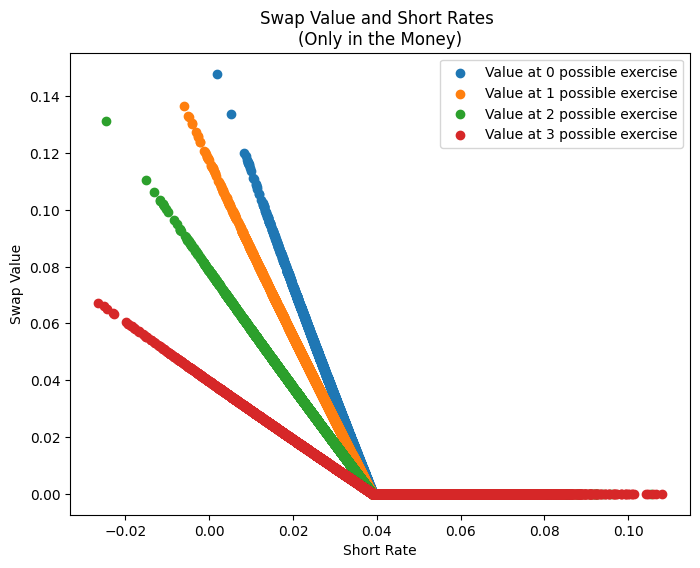

In [61]:
# Plot of values for each point of exercise (Only in the money swaps)
plt.figure(figsize=(8,6))
plt.title("Swap Value and Short Rates \n(Only in the Money)")
plt.xlabel("Short Rate")
plt.ylabel("Swap Value")

legend_val = []
for t in np.arange(tenor, T_m, tenor):
    k = int(t/tenor)-1
    plt.scatter(short_rate_paths.T[int(t*months_per_year)], np.where(simulations_swap_values.T[k] < 0, 0, simulations_swap_values.T[k]))
    legend_val.append("Value at " + str(k) + " possible exercise")
plt.legend(legend_val)
plt.show()

### Finding best exercise point and price for each path

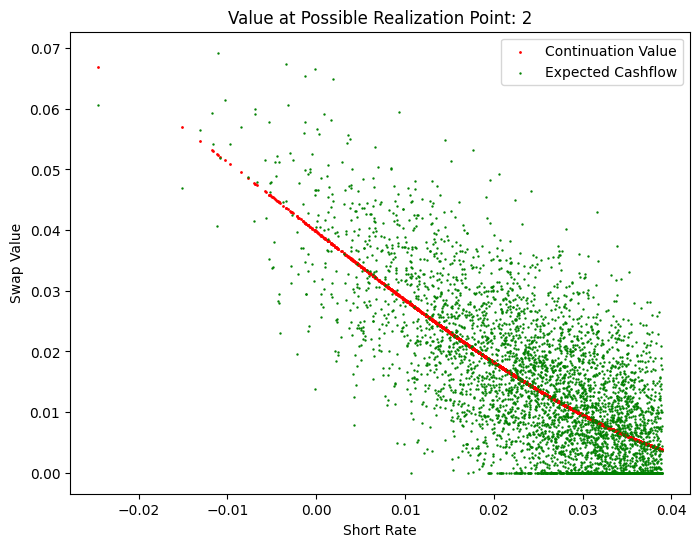

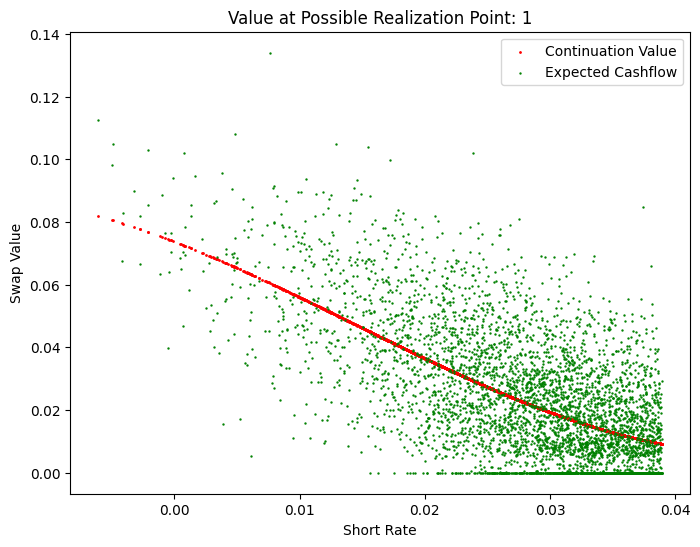

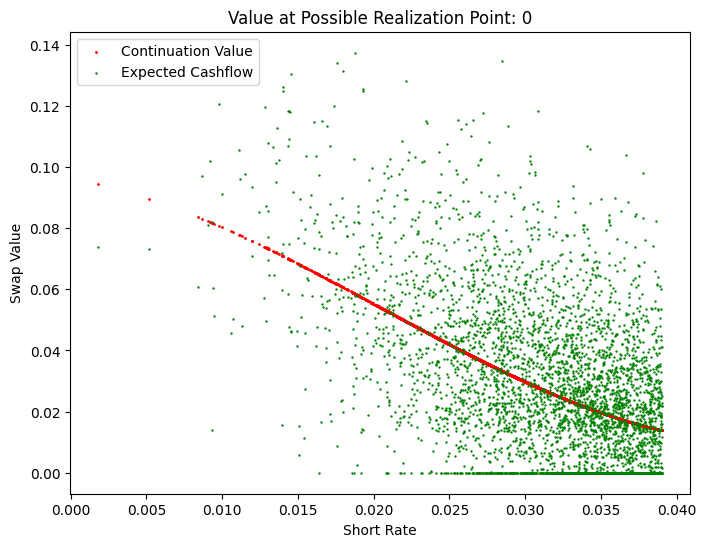

Final Realization Matrix
 [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]

In [62]:
np.set_printoptions(threshold=100000)       # To show detailed arrays

# Calculates forward rates for each path for the whole duration of simulaiton
def get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths):
    # Finding forward rates based on the simulated short rates
    forward_rate_paths_regression = []
    for simulation in range(simulations):
        forward_rates_temp = []
        for t in np.arange(0.0, T_m, tenor):
            # To be clear what is counted where, made variables as explicit as possible
            start_id = int(months_per_year*t)
            finish_id = int(months_per_year*(t+tenor))
            forward_rate = np.sum(short_rate_paths[simulation, start_id:finish_id]*dt)  # Using Reimann sum to approximate the integral for rates for correct time period
            forward_rates_temp.append(forward_rate)
        forward_rate_paths_regression.append(forward_rates_temp)
    return (np.array(forward_rate_paths_regression))         # discounting value for each period between tenors

forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)

# # Calculates forward rates for each path based on coupon value (is not as accurate)
# from scipy.misc import derivative
# def get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths):
#     # Finding forward rates based on the simulated short rates
#     forward_rate_paths_regression = []
#     for simulation in range(simulations):
#         forward_rates_temp = []
#         for t in np.arange(0.0, T_m, tenor):
#             # To be clear what is counted where, made variables as explicit as possible
#             forward_rate = -derivative(lambda x: np.log(P(t, x, short_rate_paths[simulation, int(months_per_year*t)],  a, sigma, yield_curve)), t+tenor, dx=1e-6)
#             forward_rates_temp.append(forward_rate)
#         forward_rate_paths_regression.append(forward_rates_temp)
#     return (np.array(forward_rate_paths_regression))         # discounting value for each period between tenors

# forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)

def LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, ridge_a=1.0, method="Laguerre", degree=3, visualize_regression=True):
    # Independent Variable for Regression (For first step it is just a discounted value of swap at the maturity (Discounted Realized Cashflow))
    expected_cashflow = simulations_swap_values[:, -1] * np.exp(-forward_rate_paths_regression[:, -1])
    expected_cashflow[np.where(simulations_swap_values[:, -1] < 0)] = 0.0      # If swap is not In Money, we just let it expire

    # Matrix of points where we exercise
    realization_matrix = np.zeros(simulations_swap_values.shape)
    realization_matrix[np.where(simulations_swap_values[:, -1] > 0), -1] = 1.0      # At last point we exercise if in money

    for i in range(simulations_swap_values.shape[1]-2, -1, -1):              # Starting from the back
        # For last 2 points the value is 0, no possible legs left
        # On last point we do not regress because the value is same as just swap
        # On 0th regression, the short rate at t=0 is the same for all paths
        ids_to_fit = np.where(simulations_swap_values[:, i] > 0)[0]         # Creating mask to regress only "in money" swaps
        if len(ids_to_fit) > 2:     # So that we can fit a line for prediction
            if method == "Ridge":
                Y = expected_cashflow[ids_to_fit].reshape(-1, 1)  # It is already discounted
                X_pred = short_rate_paths[ids_to_fit, int(months_per_year * (tenor * i + tenor))].reshape(-1, 1)  # Dependent variable is our short rate
                # Fit the Linear Regression model to the polynomial features
                poly = PolynomialFeatures(degree=degree)
                X_poly = poly.fit_transform(X_pred)
                model = Ridge(alpha=ridge_a).fit(X_poly, Y)
                # Predict using the polynomial features
                continuation_values = model.predict(poly.transform(short_rate_paths[ids_to_fit, int(months_per_year * (tenor * i + tenor))].reshape(-1, 1)))

            else:
                # Getting continuation Values
                Y = expected_cashflow[ids_to_fit].flatten()             # It is already discounted
                X_pred = short_rate_paths[ids_to_fit, int(months_per_year * (tenor * i + tenor))].flatten()      # Dependent variable is our short rate
                if method == "Polynomial":
                    model = Polynomial.fit(X_pred, Y, deg=degree)
                if method == "Laguerre":
                    model = Laguerre.fit(X_pred, Y, deg=degree)
                X_test = short_rate_paths[ids_to_fit, int(months_per_year * (tenor * i + tenor))].flatten()       # We need + tenor so that we offshift values to match T_0
                continuation_values = model(X_test)

            # Visualization of Regression
            if visualize_regression:
                plt.figure(figsize=(8,6))
                plt.title("Value at Possible Realization Point: " + str(i))
                plt.xlabel("Short Rate")
                plt.ylabel("Swap Value")
                plt.scatter(short_rate_paths[ids_to_fit, int(months_per_year * (tenor * i + tenor))], continuation_values, c="red", label="Continuation Value", s=1.0)
                plt.scatter(short_rate_paths[ids_to_fit, int(months_per_year * (tenor * i + tenor))], expected_cashflow[ids_to_fit], c="green", label="Expected Cashflow", s=0.5)
                plt.legend()
                plt.show()

        # Creating independent variable for the next iteration
        expected_cashflow_temp = np.zeros(simulations)
        for k in range(simulations):   # For each path we should find out if it is better to exercise or not
            if k in ids_to_fit:             # If there is any update to value during regression
                if simulations_swap_values[k, i] > continuation_values[np.where(ids_to_fit==k)] and simulations_swap_values[k, i] > 0:
                    expected_cashflow_temp[k] = simulations_swap_values[k, i] * np.exp(-forward_rate_paths_regression[k, i+1])        # We exercise and keep this value, i+1 because we have 1 more value in the beginnign for forward rates
                    realization_matrix[k,i] = 1.0           # For future reference
                    realization_matrix[k,i+1:] = 0.0        # Delete all older subsequent realizations, we keep only the earliest
                else:                       # keep the value same otherwise, discounted
                    expected_cashflow_temp[k] = expected_cashflow[k] * np.exp(-forward_rate_paths_regression[k, i+1])
            else:                           # keep the value same otherwise, discounted
                expected_cashflow_temp[k] = expected_cashflow[k] * np.exp(-forward_rate_paths_regression[k, i+1])
        expected_cashflow = expected_cashflow_temp

    if visualize_regression: print("Final Realization Matrix\n", realization_matrix)

    return realization_matrix

realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations)

### Finding fair value of swaption

In [63]:
def get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations):

    # Arrays to hold values of best exercise periods
    max_indexes = []
    max_values = []
    sim_id = []

    fair_values_t = []
    for sim in range(simulations):
        # Finding max value in array


        # If path was never exercized, i.e. its value is less than zero, we just let it expire worthless
        if (np.any(realization_matrix[sim])):

            max_index = np.argmax(realization_matrix[sim])
            max_value = simulations_swap_values[sim][max_index]
            
            # Used for later visualization
            sim_id.append(sim)
            max_indexes.append(max_index)
            max_values.append(max_value)

            # Discounting swaps values at optimal execution points
            #disc_rate = np.sum(forward_rate_paths_regression[sim, :(max_index+1)])
            disc_rate = np.sum(forward_rate_paths_regression[sim, :(max_index+1)])

            max_value_fair = max_value*np.exp(-disc_rate)
            fair_values_t.append(max_value_fair)

    fair_value_t = np.sum(fair_values_t)/simulations

    # # Calculating EU swapption value for comparison (HANDLED CORRECTLY IN ANOTHER FILE)
    # eu_option = []
    # for i in range(simulations):
    #     no_call_period = 0.0
    #     value_at_decision = V(months_per_year, no_call_period, no_call_period+tenor, T_m, N, fixed_rate, tenor, short_rate_paths[i], a, sigma, yield_curve)
    #     if value_at_decision < 0: value_at_decision = 0       # If negative, we just do not exercise
    #     eu_option.append(value_at_decision)
    # print("European Swaption Fair Value is: ", np.mean(eu_option))

    #return fair_value_t*np.exp(-r0*tenor), max_indexes, max_values, sim_id
    return fair_value_t, max_indexes, max_values, sim_id


fair_value_t, max_indexes, max_values, sim_id = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
print("Bermudan Swaption Fair Value is: ", fair_value_t)
print("Simple Swap's price for the same set of parameters is: ", V(months_per_year, 0.0, 0.0, T_m, N, fixed_rate, tenor, rates, a, sigma, yield_curve))

Bermudan Swaption Fair Value is:  0.017332531464784057
Simple Swap's price for the same set of parameters is:  -0.0036012163500057925


In [64]:
# Verifying values by running a simulation with the QuantLib (only works with flat curve for now)

def get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0):
    # Setup the market and yield term structure
    calendar = ql.TARGET()
    day_count = ql.Actual365Fixed()
    todays_date = ql.Date(1, 1, 2023)
    ql.Settings.instance().evaluationDate = todays_date
    flat_forward = ql.FlatForward(todays_date, r0, day_count)     # Flat rate curve
    yield_curve_handle = ql.YieldTermStructureHandle(flat_forward)

    # Swaption characteristics
    # Define the fixed-rate leg
    start_date = todays_date
    maturity_date = todays_date + ql.Period(int(T_m*12), ql.Months)
    fixed_leg_tenor = ql.Period(int(tenor*12), ql.Months)
    fixed_leg_schedule = ql.Schedule(start_date, maturity_date, fixed_leg_tenor, calendar,
                                    ql.ModifiedFollowing, ql.ModifiedFollowing,
                                    ql.DateGeneration.Forward, False)

    # Define the floating-rate leg
    index = ql.IborIndex("CustomEuriborM", ql.Period(int(tenor*12), ql.Months), 0, ql.EURCurrency(), calendar, ql.ModifiedFollowing, False, day_count, yield_curve_handle)
    floating_leg_schedule = ql.Schedule(start_date, maturity_date, index.tenor(), calendar,
                                        ql.ModifiedFollowing, ql.ModifiedFollowing,
                                        ql.DateGeneration.Forward, False)

    # Define the swaption
    hull_white_model = ql.HullWhite(yield_curve_handle, a, sigma)
    exercise_dates = [date for date in fixed_leg_schedule]
    exercise = ql.BermudanExercise(exercise_dates)
    swaption = ql.Swaption(ql.VanillaSwap(ql.VanillaSwap.Receiver, 1.0, fixed_leg_schedule,
                                        fixed_rate, day_count, floating_leg_schedule,
                                        index, 0.0, index.dayCounter()), exercise)
    # Setup the pricing engine
    engine = ql.TreeSwaptionEngine(hull_white_model, 200)
    swaption.setPricingEngine(engine)
    npv = swaption.NPV()


    # # Define the European swaption    (Outputs same value as swap)
    # exercise = ql.EuropeanExercise(start_date+ql.Period(int(1), ql.Days))       # Very small period is necessary, otherwise output is zero
    # european_swaption = ql.Swaption(ql.VanillaSwap(ql.VanillaSwap.Receiver, N, fixed_leg_schedule,
    #                                       fixed_rate, day_count, floating_leg_schedule,
    #                                       index, 0.0, index.dayCounter()), exercise)

    # # Setup the pricing engine for European swaption
    # european_swaption.setPricingEngine(engine)
    # european_swaption_npv = european_swaption.NPV()
    # print("QuantLib European Swaption price is: ", european_swaption_npv)


    # Define the Simple Swap
    vanilla_swap = ql.VanillaSwap(ql.VanillaSwap.Receiver, 1.0, fixed_leg_schedule,
                                fixed_rate, day_count, floating_leg_schedule,
                                index, 0.0, index.dayCounter())
    vanilla_swap.setPricingEngine(ql.DiscountingSwapEngine(yield_curve_handle))

    # Calculate the NPV
    swap_NPV = vanilla_swap.NPV()
    

    return npv, swap_NPV

npv, swap_NPV = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)
print("QuantLib Bermudan Swaption price is: ", npv)
print("QuantLib Swap price is: ", swap_NPV)

QuantLib Bermudan Swaption price is:  0.017632809939120038
QuantLib Swap price is:  -0.003608406649335899


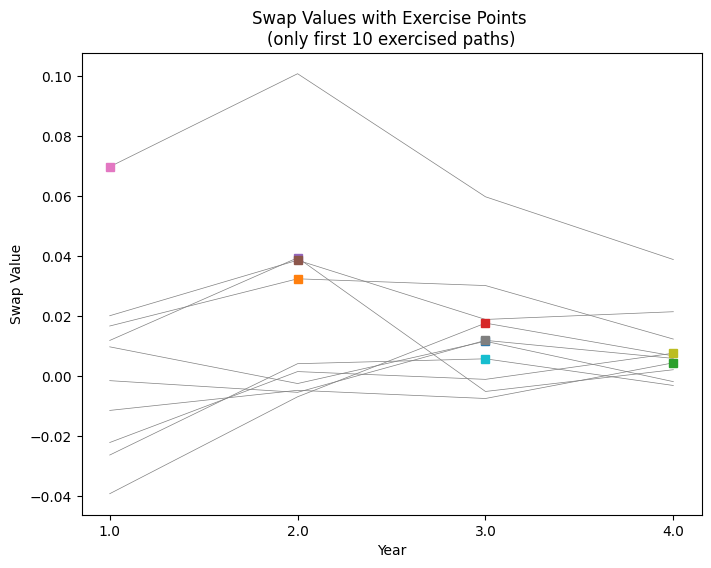

In [65]:
k=-1
for pic in range(1):
    plt.figure(k, figsize=(8,6))
    paths_to_show = 10          # Amount of paths from simulation to show
    for id in range(paths_to_show):
        k+=1
        plt.plot(simulations_swap_values[sim_id[k]], "grey", zorder=1, linewidth = '0.5')               # Draw k-th swap value path
        plt.plot(max_indexes[k], simulations_swap_values[sim_id[k]][max_indexes[k]], "s", zorder=2)     # Show exercise point
    plt.title("Swap Values with Exercise Points \n(only first " + str(paths_to_show) + " exercised paths)")
    plt.xlabel("Year")
    plt.ylabel("Swap Value")

    labels = ["%.1f" %x for x in np.linspace(tenor, T_m-tenor, int((T_m-tenor)/tenor))]
    locs = [x for x in range(len(labels))]
    plt.xticks(locs, labels)

    plt.show()

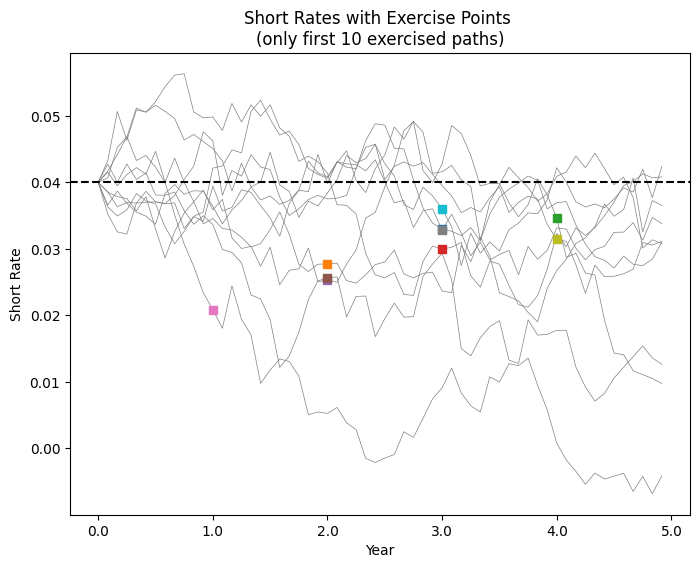

In [66]:
k=-1
finish_day_sim = int(T_m*months_per_year)
for pic in range(1):
    plt.figure(k, figsize=(8,6))
    paths_to_show = 10          # Amount of paths from simulation to show
    for id in range(paths_to_show):
        k+=1
        plt.plot(short_rate_paths[sim_id[k]][:finish_day_sim].T, "grey", zorder=1, linewidth = '0.5')       # Draw k-th short rate path
        day_point_sim = int((max_indexes[k]+1)*tenor*months_per_year)
        plt.plot(day_point_sim, short_rate_paths[sim_id[k]][day_point_sim], "s", zorder=2)

    plt.axhline(y = fixed_rate, color = 'black', linestyle = '--', zorder=3) 
    labels = ["%.1f" %x for x in np.linspace(0, T_m, int(T_m/tenor)+1)]
    locs = [x for x in np.linspace(0, T_m*months_per_year, int(T_m/tenor)+1, dtype=int)]
    plt.title("Short Rates with Exercise Point (Only Exercised Paths)")
    plt.title("Short Rates with Exercise Points \n(only first " + str(paths_to_show) + " exercised paths)")

    plt.xticks(locs, labels)
    plt.xlabel("Year")
    plt.ylabel("Short Rate")
    plt.show()

## Experiments with LSM: Estimating Error for Different Regression Methods

In [67]:
# Simulation Parameters

# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]
yield_curve = CubicSpline(durations, yields)

# Swaption parameters
T_m = 5.0              # Maximum duration of swaption (Maturity)
tenor = 0.5             # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
N = 1                   # Notional Amount

# Simulation's Parameters
months_per_year = 12         # Days in the Year
steps = int(months_per_year * T_m)
dt = 1.0 / months_per_year            # Time step size

# Parameters for the Hull-White model
simulations = 20_000
a = 0.01
sigma = 0.01
r0 = 0.04

In [68]:
fixed_rates = np.linspace(0.032, 0.048, 5)       # Strike rate

errors_poly_low_degree = []
errors_poly_degree = []
errors_poly_high_degree = []
errors_laguer_8 = []
errors_laguer_16 = []
errors_ridge = []

for trials_amount in tqdm(range(50)):

    #random_z = np.random.normal(0, 1, size=(simulations, steps))
    short_rate_paths = get_short_rates(simulations, steps, dt, r0, a, sigma, theta, yield_curve)

    #print("polynomial_3")
    bermudan_ql = []
    error_poly_low_degree = []
    error_poly_degree = []
    error_poly_high_degree = []
    error_laguer_8 = []
    error_laguer_16 = []
    error_ridge = []

    for fixed_rate in fixed_rates:
        npc, _ = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)
        bermudan_ql.append(npc)

        # Get Bermudan Values
        simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
        forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)

        # Low Degree Polynomial
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Polynomial", degree=3, visualize_regression=False)               # Wiggly, does not predict well
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        error_poly_low_degree.append(bermudan)
        # Mid Degree Polynomial
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Polynomial", degree=8, visualize_regression=False)               # Wiggly, does not predict well
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        error_poly_degree.append(bermudan)
        # High Degree Polynomial
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Polynomial", degree=16, visualize_regression=False)               # Wiggly, does not predict well
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        error_poly_high_degree.append(bermudan)
        # Laguerre Mid
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)                 # Wiggly, predicts well
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        error_laguer_8.append(bermudan)
        # Laguerre High
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=16, visualize_regression=False)                 # Wiggly, predicts well
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        error_laguer_16.append(bermudan)
        # Ridge
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, ridge_a=0.0001, method="Ridge", degree=16, visualize_regression=False)    # Not wiggly, predicts not so well
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        error_ridge.append(bermudan)

    # Finding Difference
    differences = np.abs(np.array(error_poly_low_degree)-np.array(bermudan_ql))/np.array(bermudan_ql)
    errors_poly_low_degree.append(np.mean(differences))

    differences = np.abs(np.array(error_poly_degree)-np.array(bermudan_ql))/np.array(bermudan_ql)
    errors_poly_degree.append(np.mean(differences))

    differences = np.abs(np.array(error_poly_high_degree)-np.array(bermudan_ql))/np.array(bermudan_ql)
    errors_poly_high_degree.append(np.mean(differences))

    differences = np.abs(np.array(error_laguer_8)-np.array(bermudan_ql))/np.array(bermudan_ql)
    errors_laguer_8.append(np.mean(differences))

    differences = np.abs(np.array(error_laguer_16)-np.array(bermudan_ql))/np.array(bermudan_ql)
    errors_laguer_16.append(np.mean(differences))

    differences = np.abs(np.array(error_ridge)-np.array(bermudan_ql))/np.array(bermudan_ql)
    errors_ridge.append(np.mean(differences))

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander,

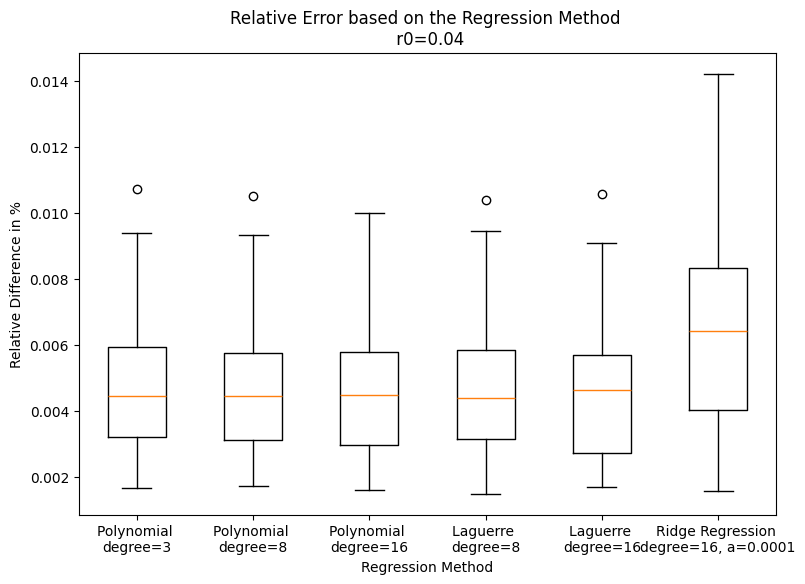

In [69]:
data = [errors_poly_low_degree, errors_poly_degree, errors_poly_high_degree, errors_laguer_8, errors_laguer_16, errors_ridge]

plt.figure(figsize=(9,6))
plt.boxplot(data)
plt.title("Relative Error based on the Regression Method \n r0=" + str(r0))
plt.xticks(np.arange(1,7), ["Polynomial \ndegree=3","Polynomial \ndegree=8","Polynomial \ndegree=16","Laguerre \ndegree=8","Laguerre \ndegree=16","Ridge Regression \ndegree=16, a=0.0001"])
plt.xlabel("Regression Method")
plt.ylabel("Relative Difference in %")

# show plot
plt.show()

## Estimating Error for different Tenors

In [70]:
# Simulation Parameters

# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]
yield_curve = CubicSpline(durations, yields)

# Simulation's Parameters
months_per_year = 12         # Days in the Year
dt = 1.0 / months_per_year            # Time step size

# Parameters for the Hull-White model
a = 0.01
sigma = 0.01
r0 = 0.04

# Swaption parameters
#fixed_rate = 0.032
fixed_rate = 0.04
#fixed_rate = 0.048
N = 1                   # Notional Amount

In [71]:
bermudan_sim1 = []
tenors = [0.25, 0.5, 1.0]
T_m = 5.0
simulations = 20_000
for tenor in tenors:
    ql_swaption, _ = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)
    print(fixed_rate, ql_swaption)
    bermudan_swaption_values = []
    for iter in tqdm(range(50)):
        short_rate_paths = get_short_rates(simulations, int(T_m*months_per_year)+1, dt, r0, a, sigma, theta, yield_curve)
        simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
        forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        bermudan_swaption_values.append(bermudan)
    bermudan_sim1.append(bermudan_swaption_values)

0.04 0.019874584083848602


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
100%|██████████| 50/50 [15:51<00:00, 19.04s/it]


0.04 0.019144300123586686


100%|██████████| 50/50 [08:21<00:00, 10.03s/it]


0.04 0.017632809939120038


100%|██████████| 50/50 [06:11<00:00,  7.43s/it]


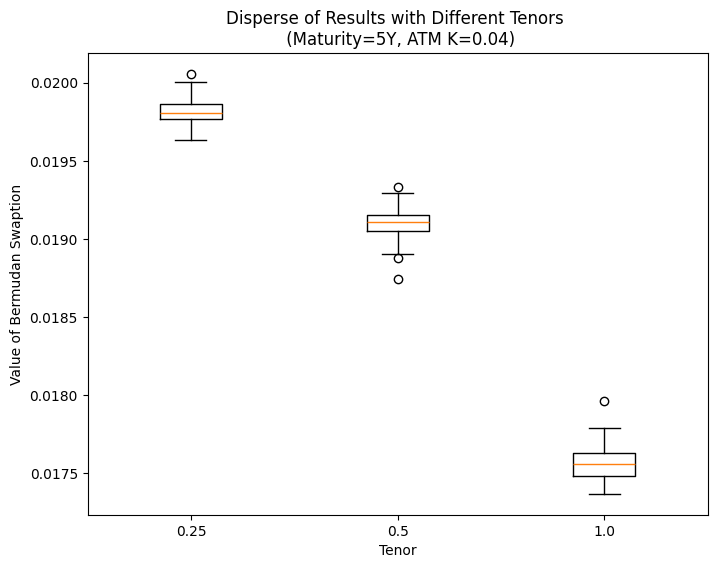

In [72]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
plt.boxplot(bermudan_sim1)
plt.title("Disperse of Results with Different Tenors \n (Maturity=5Y, ATM K=0.04)")
plt.xticks(np.arange(1, len(tenors)+1), tenors)
plt.xlabel("Tenor")
plt.ylabel("Value of Bermudan Swaption")

# show plot
plt.show()

## Estimating Error for different Maturities

In [73]:
# Simulation Parameters

# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]
yield_curve = CubicSpline(durations, yields)

# Simulation's Parameters
months_per_year = 12         # Days in the Year
dt = 1.0 / months_per_year            # Time step size

# Parameters for the Hull-White model
a = 0.01
sigma = 0.01
r0 = 0.04

# Swaption parameters
#fixed_rate = 0.032
fixed_rate = 0.04
#fixed_rate = 0.048
N = 1                   # Notional Amount

In [74]:
bermudan_sim2 = []
tenor = 0.5
T_m_s = [1.0, 2.0, 5.0, 10.0]
simulations = 20_000
for T_m in T_m_s:
    ql_swaption, _ = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)
    print(fixed_rate, ql_swaption)
    bermudan_swaption_values = []
    for iter in tqdm(range(50)):
        short_rate_paths = get_short_rates(simulations, int(T_m*months_per_year)+1, dt, r0, a, sigma, theta, yield_curve)
        simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
        forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        bermudan_swaption_values.append(bermudan)
    bermudan_sim2.append(bermudan_swaption_values)

0.04 0.0012872676170364835


100%|██████████| 50/50 [04:09<00:00,  4.99s/it]


0.04 0.004760323101828713


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
100%|██████████| 50/50 [05:08<00:00,  6.17s/it]


0.04 0.019144300123586686


100%|██████████| 50/50 [08:25<00:00, 10.11s/it]


0.04 0.0481725774860661


100%|██████████| 50/50 [17:24<00:00, 20.88s/it]


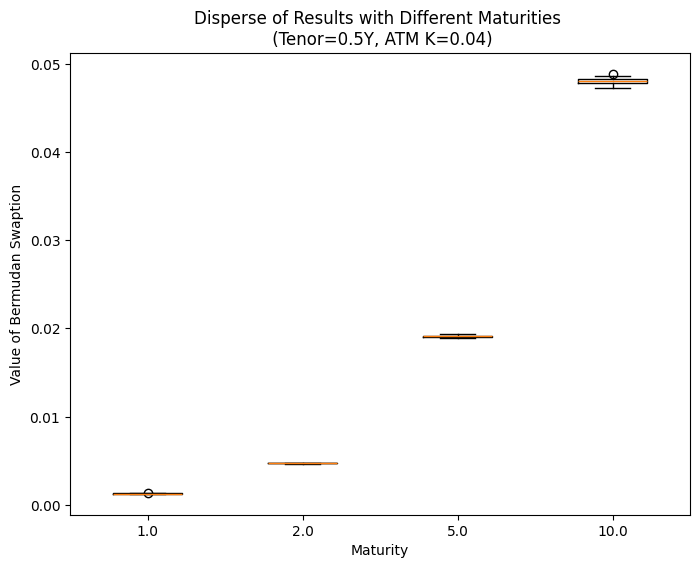

In [75]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize = (8, 6))
plt.boxplot(bermudan_sim2)
plt.title("Disperse of Results with Different Maturities \n (Tenor=0.5Y, ATM K=0.04)")
plt.xticks(np.arange(1, len(T_m_s)+1), T_m_s)
plt.xlabel("Maturity")
plt.ylabel("Value of Bermudan Swaption")

# show plot
plt.show()

## Estimating Error for different fixed rates

In [76]:
# Simulation Parameters

# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]
yield_curve = CubicSpline(durations, yields)

# Simulation's Parameters
months_per_year = 12         # Days in the Year
dt = 1.0 / months_per_year            # Time step size

# Parameters for the Hull-White model
a = 0.01
sigma = 0.01
r0 = 0.04

# Swaption parameters
T_m = 5.0              # Maximum duration of swaption (Maturity)
tenor = 0.5             # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
N = 1                   # Notional Amount

In [77]:
bermudan_sim3 = []
fixed_rates = np.linspace(0.032, 0.048, 5)
simulations = 20_000
for fixed_rate in fixed_rates:
    ql_swaption, _ = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)
    print(fixed_rate, ql_swaption)
    bermudan_swaption_values = []
    for iter in tqdm(range(50)):
        short_rate_paths = get_short_rates(simulations, int(T_m*months_per_year)+1, dt, r0, a, sigma, theta, yield_curve)
        simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
        forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        bermudan_swaption_values.append(bermudan)
    bermudan_sim3.append(bermudan_swaption_values)

0.032 0.009105425565638356


  4%|▍         | 2/50 [00:19<07:42,  9.64s/it]c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
100%|██████████| 50/50 [07:56<00:00,  9.52s/it]


0.036000000000000004 0.013332811784962621


100%|██████████| 50/50 [08:07<00:00,  9.75s/it]


0.04 0.019144300123586686


100%|██████████| 50/50 [08:24<00:00, 10.09s/it]


0.044 0.02694458699785877


100%|██████████| 50/50 [09:20<00:00, 11.21s/it]


0.048 0.037085415213745976


100%|██████████| 50/50 [09:39<00:00, 11.59s/it]


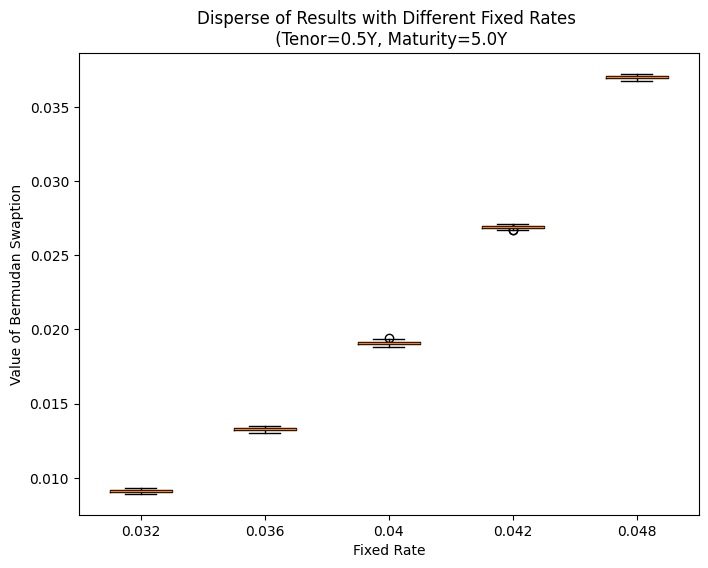

In [92]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,6))
plt.boxplot(bermudan_sim3)
plt.title("Disperse of Results with Different Fixed Rates \n (Tenor=0.5Y, Maturity=5.0Y")
plt.xticks(np.arange(1, len(fixed_rates)+1), fixed_rates)
plt.xlabel("Fixed Rate")
plt.ylabel("Value of Bermudan Swaption")

# show plot
plt.show()

## Convergence Results

### ATM

In [79]:
# Simulation Parameters

# Flat Yield Curve
flat_yields = [
    (0.5, .04),
    (2.0, .04),
    (5.0, .04),
    (10.0, .04),
]
yield_curve = flat_yields
durations = [item[0] for item in yield_curve]
yields = [item[1] for item in yield_curve]
yield_curve = CubicSpline(durations, yields)

# Simulation's Parameters
months_per_year = 12         # Days in the Year
dt = 1.0 / months_per_year            # Time step size

# Parameters for the Hull-White model
a = 0.01
sigma = 0.01
r0 = 0.04

# Swaption parameters
T_m = 5.0               # Maximum duration of swaption (Maturity)
tenor = 0.5             # Semi-Annual settlements (First settlement is assumed to be possible after this period too)
fixed_rate = 0.04       # Strike rate
N = 1                   # Notional Amount

In [80]:
# Calculating Results with CI
def get_conf_int(trials):
    print(trials)
    # Some variables necessary for statistical tests
    confidence_level = 0.95
    d_f = simulations - 1
    # T-test for the Mean
    t_critical = stats.t.ppf((1 + confidence_level) / 2, d_f)

    # Mean
    overall_sim_mean = np.mean(trials)
    # Confidence Interval for the mean
    mean_err = stats.sem(trials)  # Standard Error Mean
    ci_mean = t_critical * mean_err
    return overall_sim_mean, ci_mean

In [81]:
ql_swaption, _ = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)

bermudan_sim = []
bermudan_sim_ci = []
sim_range = [200, 1000, 2500, 10_000, 100_000]
for simulations in sim_range:
    bermudan_swaption_values = []
    for iter in tqdm(range(50)):
        short_rate_paths = get_short_rates(simulations, int(T_m*months_per_year)+1, dt, r0, a, sigma, theta, yield_curve)
        simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
        forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        bermudan_swaption_values.append(bermudan)
    npv, ci = get_conf_int(bermudan_swaption_values)
    bermudan_sim.append(npv)
    bermudan_sim_ci.append(ci)

100%|██████████| 50/50 [03:44<00:00,  4.50s/it]


[0.02044490937188472, 0.019055621584031728, 0.018709880587081246, 0.01976108602784742, 0.019484567151962513, 0.02050768455358933, 0.01975659072722765, 0.01963005616469406, 0.01976081670083131, 0.020113126398478308, 0.01978241280687388, 0.019016751222911375, 0.01941140734120134, 0.018888247534890816, 0.020971196504792226, 0.01988455072679885, 0.01904796395072393, 0.019431962424821637, 0.022601154823651073, 0.018812801397886367, 0.01816016627046584, 0.02000255705327637, 0.0209468165326242, 0.020525515055237555, 0.018497661378537592, 0.01975007250053857, 0.019502059637625746, 0.020995744054279265, 0.020309366047077112, 0.020547239597053676, 0.019679419052068395, 0.019735606135392617, 0.021242351387099383, 0.02029653847867504, 0.020952247157586507, 0.020089238232735937, 0.02033554492166572, 0.020782063166398402, 0.020295337672891742, 0.020264827979351203, 0.019746148562033775, 0.018676488419633132, 0.0211151796308805, 0.019810212188946505, 0.01935636501666899, 0.01854707177527647, 0.018654

100%|██████████| 50/50 [03:46<00:00,  4.54s/it]


[0.01879113113764342, 0.01898530188965098, 0.01956453906554122, 0.019162622524491597, 0.019474483262889437, 0.019675327014620506, 0.019032182870087483, 0.01913958673648825, 0.019369324576737075, 0.018687522900419994, 0.01874706836437243, 0.019647473759062593, 0.01946028409431362, 0.01970118905010886, 0.0196704760387772, 0.01895628919205521, 0.019095987363280723, 0.01870665106939219, 0.018998030462033112, 0.01991272310543126, 0.01967562619551207, 0.019506217307278934, 0.02002928479090412, 0.019422347694753227, 0.019922362207375408, 0.018807044225004992, 0.019114156903892374, 0.01907881057865732, 0.019074543140630472, 0.019486825058390125, 0.01872885887832399, 0.01928073598840882, 0.01913820807317498, 0.018991922824728818, 0.019556433912423017, 0.019592340696408517, 0.019156935332821996, 0.01910031927871595, 0.01979013848574528, 0.018654289231784908, 0.01871917263581731, 0.01927242128165405, 0.0191166262615871, 0.019513554354695792, 0.01935274152233538, 0.019086730990118476, 0.0191661586

100%|██████████| 50/50 [04:02<00:00,  4.85s/it]


[0.019170120749684775, 0.01906544987140658, 0.01922525354275983, 0.019074205154682212, 0.019436989727238084, 0.019282216846825635, 0.019265136293682452, 0.0192303113293325, 0.019115778541138103, 0.019255655402735782, 0.019119068359008323, 0.01924955914480088, 0.019210328866502306, 0.01892729989716278, 0.01964577152186127, 0.0189293196952411, 0.0195907107427918, 0.01920674260778555, 0.018890049354479042, 0.019232562616763402, 0.019054108041911627, 0.018850595350626578, 0.01879229886757479, 0.018732749815995754, 0.01967602194231567, 0.019279123165299686, 0.018725569062487468, 0.01920478890632922, 0.019101845611363372, 0.01893756141558461, 0.0193818251234527, 0.018913364674502522, 0.018921672888344062, 0.0189846019964978, 0.01910439756750669, 0.01912338401206257, 0.019074538777322073, 0.019653760872188453, 0.018532968053571262, 0.018727303496098257, 0.0191860535010611, 0.01894279335793406, 0.01973581098612035, 0.019038219544622224, 0.019495590935825435, 0.019507021181687, 0.01973002445390

 18%|█▊        | 9/50 [01:05<04:56,  7.22s/it]c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
100%|██████████| 50/50 [06:08<00:00,  7.38s/it]


[0.019172979297172984, 0.01912398112309376, 0.019124582487652444, 0.01910642979964274, 0.01916618367768014, 0.01883443888619397, 0.01902563091535464, 0.01890248067472344, 0.019079140046667848, 0.01911994608477283, 0.019173090357420642, 0.01897675851212598, 0.01924883234042212, 0.019104179764335733, 0.019075384443801777, 0.019159574601783774, 0.019018486884167227, 0.019066864406942153, 0.019266154462673893, 0.0192475773990536, 0.01903652687539693, 0.019065347562750325, 0.019147214457521135, 0.018891739906372378, 0.01882567756072263, 0.019125144903298856, 0.019143577807868583, 0.0192106160765217, 0.018882941613688392, 0.019048013417275966, 0.01899055394580926, 0.018700177726696448, 0.019205117604510394, 0.019171371763016004, 0.01903352698853254, 0.019137428988185375, 0.01921038399492671, 0.019084848952832658, 0.01937611753582605, 0.01894505175566926, 0.019077362946077425, 0.019108295620317267, 0.019010961394389774, 0.019203223401276403, 0.019114278377832118, 0.019170462804846786, 0.01912

100%|██████████| 50/50 [42:45<00:00, 51.31s/it]

[0.019113573610517125, 0.019118176943776516, 0.019127361856490912, 0.019110603632236666, 0.01914182049255497, 0.019093232968846293, 0.019073936847988124, 0.019115925607171732, 0.01908411839294017, 0.01910114179373837, 0.019072653549794608, 0.019022196122963114, 0.019125493488736725, 0.019174902310501413, 0.019064071398534187, 0.019102841528310554, 0.01910652208483924, 0.01909817676603297, 0.01910308299100059, 0.01902493135523082, 0.019064683358721773, 0.019064528987733767, 0.01911247619851432, 0.019072019222557496, 0.01905790191827264, 0.019045903314276972, 0.019089334879709374, 0.01911805983308511, 0.01906458345868034, 0.019060571125957472, 0.01908527812317495, 0.01906171398710758, 0.019109359849911342, 0.019090975608918762, 0.0190833490774801, 0.019044423078177816, 0.01915012656502706, 0.019096459908647237, 0.01905382586733487, 0.01916483482749661, 0.01912429878783206, 0.019130146780392876, 0.019041649415223717, 0.01907863748183933, 0.0189806174366417, 0.019036495274053048, 0.0191292

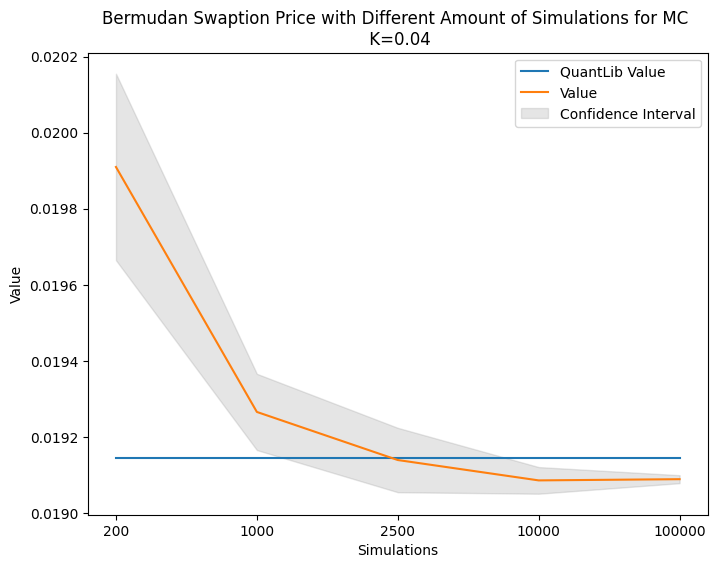

In [82]:
# Upper and lower bounds of the confidence interval
bermudan_sim4 = np.array(bermudan_sim)
bermudan_sim_ci4 = np.array(bermudan_sim_ci)

lower_bound = bermudan_sim4 - bermudan_sim_ci4
upper_bound = bermudan_sim4 + bermudan_sim_ci4

# Plotting
plt.figure(figsize=(8,6))
plt.plot(np.ones(len(bermudan_sim4))*ql_swaption, label='QuantLib Value')       # QuantLib's value
plt.plot(bermudan_sim4, label='Value')  # Plot the main line
plt.fill_between(np.arange(len(bermudan_sim4)), lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')
plt.xticks(np.arange(len(sim_range)), (sim_range))
plt.title('Bermudan Swaption Price with Different Amount of Simulations for MC \n K=' + str(fixed_rate))
plt.xlabel('Simulations')
plt.ylabel('Value')
plt.legend()
plt.show()


### 120 ITM

In [83]:
fixed_rate = 0.048       # Strike rate

ql_swaption, _ = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)

bermudan_sim = []
bermudan_sim_ci = []
sim_range = [200, 1000, 2500, 10_000, 100_000]
for simulations in sim_range:
    bermudan_swaption_values = []
    for iter in tqdm(range(50)):
        short_rate_paths = get_short_rates(simulations, int(T_m*months_per_year)+1, dt, r0, a, sigma, theta, yield_curve)
        simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
        forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        bermudan_swaption_values.append(bermudan)
    npv, ci = get_conf_int(bermudan_swaption_values)
    bermudan_sim.append(npv)
    bermudan_sim_ci.append(ci)

100%|██████████| 50/50 [03:37<00:00,  4.35s/it]


[0.03483451918735124, 0.03850003653568198, 0.03636875370073302, 0.03729607318726023, 0.039496595141415854, 0.03671067910012901, 0.03710190429544682, 0.036221320422859596, 0.038319539247327825, 0.03792089095726559, 0.03682186321379901, 0.036525593894236895, 0.03773919527413192, 0.03737690886578004, 0.037950738100639266, 0.037153554265978314, 0.03534113703234711, 0.036640273269693664, 0.0377430735508749, 0.03759283786120851, 0.03632274788005713, 0.03802419279297184, 0.0373325311789128, 0.037526543871324015, 0.03683214749274557, 0.0367343944748475, 0.0393588860638969, 0.03864850528995833, 0.03759998907484491, 0.03587803485877007, 0.038706751652728695, 0.03869202131480676, 0.03834241021827583, 0.036956900159208904, 0.038405902499612836, 0.0378449330820016, 0.03868315489934939, 0.03762179362410025, 0.036660080061740694, 0.03661250688992759, 0.03621346316072338, 0.03647639578224507, 0.038487282366770036, 0.03965846129298461, 0.038527623712647466, 0.03703712408549023, 0.036686501686401994, 0.

100%|██████████| 50/50 [03:50<00:00,  4.61s/it]


[0.036767834342065264, 0.036472931218989174, 0.0364152204111503, 0.036934323396594346, 0.03749258274615471, 0.037338084397592, 0.03665172832615503, 0.03725851399760164, 0.03629294639363802, 0.037887318633031755, 0.03770622233204654, 0.037107047157293786, 0.03681848295652135, 0.037702016832666205, 0.03793254476970938, 0.03687074499590666, 0.03586396589370887, 0.036888072708294646, 0.03633375349771327, 0.03700148884762832, 0.03717732142287564, 0.03675685957545581, 0.03736509790271838, 0.0367227356361543, 0.038269940256916435, 0.03789983311163007, 0.03570028060908731, 0.036872844513014445, 0.03695837045137773, 0.037577962972919834, 0.03689111528915708, 0.03723795689392968, 0.03728242556548554, 0.037693789537633346, 0.03714368529148372, 0.036671295506895435, 0.036625930863494985, 0.036309621745259146, 0.03687305137188659, 0.03681470384056306, 0.03768852211930043, 0.03698868349397915, 0.036883087088953645, 0.037800326454144655, 0.03694605370610753, 0.03745804661243393, 0.03626309136163073, 

100%|██████████| 50/50 [04:00<00:00,  4.81s/it]


[0.037108427131122224, 0.03684601868917885, 0.03676800926344725, 0.0367161278998111, 0.03678513471848217, 0.03750688900258538, 0.0367376177132458, 0.03760656861091056, 0.036887791264855634, 0.036657198168998435, 0.03718387402124396, 0.03771801627748217, 0.03701593115588197, 0.03696745868296227, 0.03657307867200275, 0.03654256486968797, 0.037267767387954044, 0.036581995660307134, 0.03654340493366497, 0.03707092736121782, 0.03708080228472444, 0.036548737116025146, 0.03714397497809091, 0.03736712744746446, 0.03689422716038923, 0.03698135093341181, 0.03734731725982514, 0.03735836026518927, 0.037048566408403705, 0.037412904678666634, 0.036762903923125874, 0.037169510095913065, 0.03693133477083064, 0.03678714604616076, 0.037096163476036316, 0.03703725786649941, 0.0367470447075073, 0.03701519241178267, 0.03734701633193819, 0.036774633056215845, 0.03662666642911719, 0.03739499998946425, 0.03642718291793776, 0.03658330556338714, 0.03699738906018842, 0.03677306056103749, 0.037149593862794, 0.037

  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
100%|██████████| 50/50 [06:12<00:00,  7.45s/it]


[0.03683520934614948, 0.03726443004626887, 0.036927177083706166, 0.03717674888262492, 0.036673997448385356, 0.0367705896561056, 0.03692545448300175, 0.037030205577134684, 0.03697689190509188, 0.03701228365749229, 0.03686584522153181, 0.037217102860595395, 0.03704853354060115, 0.03686907180816374, 0.03707443754062183, 0.03719606780333631, 0.037121370286221506, 0.036832887690981635, 0.03696636206085317, 0.036654565424312856, 0.03720462681227253, 0.03698495109111684, 0.03712155790392501, 0.036871928804203494, 0.03683930104405135, 0.03688351209508413, 0.0373139506686302, 0.03707265291006512, 0.037028094808975405, 0.037024176266165235, 0.03669821934668059, 0.037082315119114105, 0.036929927124789395, 0.03695128442150058, 0.0370347212166441, 0.0368162082959529, 0.037177736917002366, 0.037042307290433896, 0.0371296041175161, 0.03689249495328229, 0.036970438923811556, 0.03693159424504205, 0.03713902346299829, 0.03703462254650116, 0.0373406776049748, 0.037032185194808116, 0.03719367254206034, 0.

100%|██████████| 50/50 [51:54<00:00, 62.29s/it]

[0.037050760618655955, 0.0370020981742297, 0.03695776871679378, 0.037009586230722424, 0.036979807669218705, 0.037046849145850526, 0.03698579353413065, 0.03701789896656624, 0.03700606305287738, 0.037001236167851476, 0.036993056411466996, 0.03705796565935887, 0.03700156071642927, 0.0369358396006237, 0.03697579952408331, 0.03698629952842217, 0.036949920212927354, 0.036964160078536826, 0.037019102761896246, 0.03694585723285963, 0.036890029081388304, 0.03689652041219418, 0.036995761637987616, 0.036991814797457286, 0.03700225439350372, 0.03703952096200772, 0.036898944116962616, 0.03692079979852681, 0.03692015920495833, 0.03702303336575915, 0.03701186942773892, 0.03702315154445215, 0.03701988477821687, 0.03700519055649315, 0.03697337251745934, 0.03699071160004811, 0.03701075232763862, 0.03690337740848604, 0.0369818537745502, 0.037003999170656346, 0.03689143543805199, 0.03704340135253416, 0.03701626692828789, 0.036957052442615844, 0.03696521321445193, 0.03688405034940218, 0.036960425113951666,

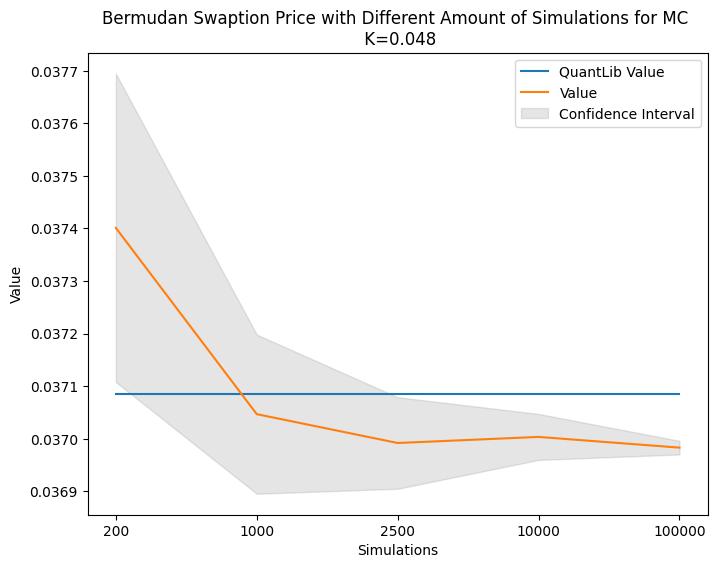

In [84]:
# Upper and lower bounds of the confidence interval
bermudan_sim5 = np.array(bermudan_sim)
bermudan_sim_ci5 = np.array(bermudan_sim_ci)

lower_bound = bermudan_sim5 - bermudan_sim_ci5
upper_bound = bermudan_sim5 + bermudan_sim_ci5

# Plotting
plt.figure(figsize=(8,6))
plt.plot(np.ones(len(bermudan_sim5))*ql_swaption, label='QuantLib Value')       # QuantLib's value
plt.plot(bermudan_sim5, label='Value')  # Plot the main line
plt.fill_between(np.arange(len(bermudan_sim5)), lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')
plt.xticks(np.arange(len(sim_range)), (sim_range))
plt.title('Bermudan Swaption Price with Different Amount of Simulations for MC \n K=' + str(fixed_rate))
plt.xlabel('Simulations')
plt.ylabel('Value')
plt.legend()
plt.show()


### 80 OTM

In [85]:
fixed_rate = 0.032       # Strike rate
ql_swaption, _ = get_fair_value_ql(T_m, tenor, a, sigma, fixed_rate, r0)

bermudan_sim = []
bermudan_sim_ci = []
sim_range = [200, 1000, 2500, 10_000, 100_000]
for simulations in sim_range:
    bermudan_swaption_values = []
    for iter in tqdm(range(50)):
        short_rate_paths = get_short_rates(simulations, int(T_m*months_per_year)+1, dt, r0, a, sigma, theta, yield_curve)
        simulations_swap_values = get_simulations_swap_values(simulations, months_per_year, T_m, tenor, N, fixed_rate, short_rate_paths, yield_curve, a, sigma)
        forward_rate_paths_regression = get_forward_rates(simulations, months_per_year, dt, T_m, tenor, short_rate_paths)
        realization_matrix = LSM(simulations_swap_values, forward_rate_paths_regression, short_rate_paths, months_per_year, tenor, simulations, method="Laguerre", degree=8, visualize_regression=False)
        bermudan, _, _, _ = get_fair_value(realization_matrix, simulations_swap_values, forward_rate_paths_regression, simulations)
        bermudan_swaption_values.append(bermudan)
    npv, ci = get_conf_int(bermudan_swaption_values)
    bermudan_sim.append(npv)
    bermudan_sim_ci.append(ci)

100%|██████████| 50/50 [03:40<00:00,  4.42s/it]


[0.009905091164917943, 0.010375082846645775, 0.010878094325294154, 0.010430434274654026, 0.009117925449405038, 0.009832707229574288, 0.009518204246500003, 0.01105215264413888, 0.010688984757062132, 0.00966192648849359, 0.011876429335298306, 0.008661106905163635, 0.009830727335781556, 0.011535725732097149, 0.010513278553143086, 0.010595476798960599, 0.009916701913798924, 0.01020004859469528, 0.008791000878788414, 0.010679906540202667, 0.009658461184182822, 0.010921975922952649, 0.010535317151172561, 0.009708482118128381, 0.008929179483401972, 0.009897062990286011, 0.010364515464514288, 0.011547564986068735, 0.012058318237881923, 0.009318263640963642, 0.010970592950398402, 0.010028262856974206, 0.010552667489287388, 0.010474752549491508, 0.008657185358960534, 0.010685069230353353, 0.010260905326043677, 0.011780739885663053, 0.010129670369020604, 0.008747507093046877, 0.010461084735192505, 0.009866202356399643, 0.011049062699786677, 0.00820913544437489, 0.009948338451523863, 0.00899063243

100%|██████████| 50/50 [03:35<00:00,  4.30s/it]


[0.009402704746239688, 0.009290554789805516, 0.008965176092292873, 0.009209024775317187, 0.00929504087524646, 0.009009406216333834, 0.008894376710647202, 0.008927186246126262, 0.009682883430129746, 0.009329929802573318, 0.009028835268570637, 0.009073227650271515, 0.009941383374235755, 0.009424775253702618, 0.009252240027674361, 0.00946467199593184, 0.009581731266074369, 0.009573788280574324, 0.008874211901580588, 0.00905454044745392, 0.009164109242903848, 0.008536728090747254, 0.009007858528045589, 0.009004544686483902, 0.01008163603385837, 0.00909815188685763, 0.00929782398231997, 0.008803607319348577, 0.009133064874759572, 0.009725943719905213, 0.009145473147567095, 0.009838866048902948, 0.009096567610615957, 0.009894796769367132, 0.008965097163675002, 0.008869998188973388, 0.009815646260918789, 0.009010222706654216, 0.009680483453139318, 0.009869526477286564, 0.00999502618041361, 0.009642985378059826, 0.008735570452528981, 0.009117090163513877, 0.008459302542652892, 0.00983094260657

100%|██████████| 50/50 [03:59<00:00,  4.80s/it]


[0.008903231770487194, 0.00961963510428668, 0.009333501952168711, 0.008930846836066299, 0.00929830402832044, 0.009090613452711881, 0.009277778214825614, 0.009076331102501393, 0.009032511611876314, 0.008979182254451865, 0.008757583260108746, 0.009111809214379608, 0.009072388930470063, 0.00925776418881361, 0.008812859030557708, 0.009586684861844616, 0.009206078588330507, 0.00911520224126222, 0.009086768582899554, 0.009377084029417119, 0.009476481158094503, 0.008977442362268724, 0.008908354569977205, 0.009125219281859887, 0.00879577042087063, 0.008932665630705675, 0.009147040730394893, 0.009052056354368884, 0.008911227995735743, 0.009038834401903482, 0.009336357410755681, 0.00912989726884064, 0.009541567957548262, 0.009064821268387141, 0.008766485217194954, 0.009063970026899994, 0.008733749965805705, 0.008853418495895366, 0.009153240498621056, 0.009064554612698774, 0.009324962043170038, 0.009197262676807755, 0.009223469098797437, 0.009104087188287542, 0.009081760451612691, 0.0088858524359

 26%|██▌       | 13/50 [01:37<04:40,  7.58s/it]c:\Users\PAOvi\anaconda3\envs\All-You-Need\lib\site-packages\numpy\polynomial\laguerre.py:1401: RankWarning: The fit may be poorly conditioned
  return pu._fit(lagvander, x, y, deg, rcond, full, w)
100%|██████████| 50/50 [06:20<00:00,  7.62s/it]


[0.009156701523560243, 0.009184086671722378, 0.00914151521849203, 0.009132685842808607, 0.009295337104156936, 0.009194971159044467, 0.008997889789094996, 0.00930562718521701, 0.009030191711401106, 0.009137514005310977, 0.009144977884855235, 0.009205302076946352, 0.008872120325153252, 0.009041592409603075, 0.0089535590050204, 0.009165955144394217, 0.009388493928595818, 0.00911048692082519, 0.008961140431237182, 0.009097130908748948, 0.00925195649243522, 0.009325205606947643, 0.009075636089887026, 0.009370649236301076, 0.009316649582723041, 0.009088311184903126, 0.009058909227722345, 0.00898427824071424, 0.009210895722842064, 0.009195000652075071, 0.009004523998645592, 0.009150600420418093, 0.009089391480455504, 0.009008285385753512, 0.009082565378716935, 0.008884426365388321, 0.00913411597497308, 0.008942341479964812, 0.008960759886291308, 0.00901824949075195, 0.009190187962640484, 0.008778524433574932, 0.008915254850359369, 0.00926031195439418, 0.008963351298227036, 0.00911564188840144

100%|██████████| 50/50 [36:04<00:00, 43.29s/it]

[0.008994538343850968, 0.009053464289645022, 0.00910168118460727, 0.009070226526184434, 0.009047566321414104, 0.009046482348422636, 0.009094266085208679, 0.009117590436076252, 0.009100361530978924, 0.00904931795510454, 0.009029174570698023, 0.009108575829358933, 0.009083732633844448, 0.009080868459522773, 0.009055288475956014, 0.009090934889212494, 0.009072797915581451, 0.009068280528987996, 0.009081831027482452, 0.00912825033413468, 0.00906171569240187, 0.009072529008748621, 0.00905591582553579, 0.009102911297629234, 0.009110638590127337, 0.009074038275244554, 0.00915406891370469, 0.009092438104966415, 0.009058295272859075, 0.009029729311295507, 0.009081259278260539, 0.009004924335192501, 0.009070092196322151, 0.009143292571936855, 0.009054006390674435, 0.009050481438294155, 0.009091016751703426, 0.009083778145920119, 0.009042638419272747, 0.009063521122949614, 0.009067184786021995, 0.009078883536023865, 0.00916655411074978, 0.009068029712326505, 0.009100032049406768, 0.00902244459950

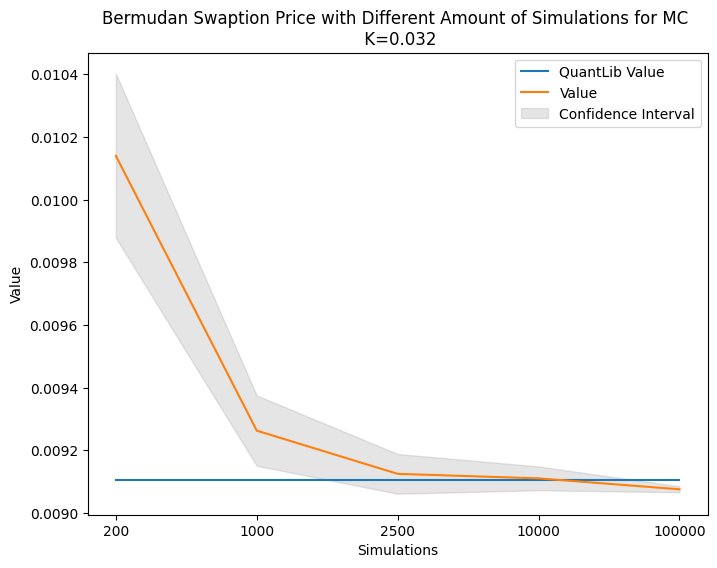

In [88]:
# Upper and lower bounds of the confidence interval
bermudan_sim6 = np.array(bermudan_sim)
bermudan_sim_ci6 = np.array(bermudan_sim_ci)

lower_bound = bermudan_sim6 - bermudan_sim_ci
upper_bound = bermudan_sim6 + bermudan_sim_ci

# Plotting
plt.figure(figsize=(8,6))
plt.plot(np.ones(len(bermudan_sim6))*ql_swaption, label='QuantLib Value')       # QuantLib's value
plt.plot(bermudan_sim6, label='Value')  # Plot the main line
plt.fill_between(np.arange(len(bermudan_sim6)), lower_bound, upper_bound, color='gray', alpha=0.2, label='Confidence Interval')
plt.xticks(np.arange(len(sim_range)), (sim_range))
plt.title('Bermudan Swaption Price with Different Amount of Simulations for MC \n K=' + str(fixed_rate))
plt.xlabel('Simulations')
plt.ylabel('Value')
plt.legend()
plt.show()